In [1]:
# =========================
# Cell 1: Setup / Imports
# =========================
import os, random, math, time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# For metrics / plots (optional but useful)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
@dataclass
class CFG:
    # Paths (set this to your Kaggle dataset root)
    data_root: str = "/kaggle/input/plantvillage-potato-disease-dataset/PlantVillage"  # <-- change if needed

    # Data
    img_size: int = 384            # EfficientNetV2-S likes 384 well
    batch_size: int = 32           # adjust based on GPU memory
    num_workers: int = 2

    # Training
    epochs: int = 15
    lr: float = 3e-4               # good starting LR for finetuning
    weight_decay: float = 1e-4
    label_smoothing: float = 0.05
    early_stopping_patience: int = 4

    # Reproducibility
    seed: int = 42

    # Mixed precision
    use_amp: bool = True

    # For split
    val_ratio: float = 0.15

cfg = CFG()

# -------------------------
# Seed everything
# -------------------------
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Make results deterministic-ish (can slightly reduce speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# =========================
# Cell 2: Paths / Sanity Check
# =========================
data_root = Path(cfg.data_root)

# Try to find the main image folder automatically
# Common patterns: data_root/train or data_root/Potato or data_root/dataset
candidates = [
    data_root / "train",
    data_root / "Train",
    data_root,
]

train_dir = None
for c in candidates:
    if c.exists() and any(p.is_dir() for p in c.iterdir()):
        # check if it looks like class folders
        subdirs = [p for p in c.iterdir() if p.is_dir()]
        # If subdirs contain images inside, we treat it as dataset root for ImageFolder
        if len(subdirs) >= 2:
            train_dir = c
            break

if train_dir is None:
    raise FileNotFoundError(
        f"Could not find a valid dataset directory inside: {data_root}\n"
        f"Please set cfg.data_root correctly."
    )

print("Using dataset directory:", train_dir)

# Peek class folders
class_folders = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])
print("Class folders found:", class_folders)


Using dataset directory: /kaggle/input/plantvillage-potato-disease-dataset/PlantVillage
Class folders found: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [3]:
# =========================
# Cell 3: Dataset + Split
# =========================
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedShuffleSplit

# We'll first load ImageFolder with a placeholder transform; transforms are set later
base_ds = datasets.ImageFolder(root=str(train_dir), transform=None)
targets = np.array(base_ds.targets)

num_classes = len(base_ds.classes)
print("Detected classes:", base_ds.classes)
print("Num classes:", num_classes)

# Stratified split (keeps class balance)
sss = StratifiedShuffleSplit(n_splits=1, test_size=cfg.val_ratio, random_state=cfg.seed)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

train_ds = Subset(base_ds, train_idx)
val_ds   = Subset(base_ds, val_idx)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)}")


Detected classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Num classes: 3
Train size: 1829 | Val size: 323


In [4]:
# =========================
# Cell 4: Transforms + Loaders
# =========================
from torchvision import transforms

# ImageNet normalization (matches pretrained weights)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.70, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.03),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.15),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Attach transforms to underlying ImageFolder via wrapper
class TransformSubset(torch.utils.data.Dataset):
    """Applies a transform to a Subset of an ImageFolder cleanly."""
    def __init__(self, subset: Subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]  # returns PIL image, label (transform=None in base_ds)
        x = self.transform(x)
        return x, y

train_ds_t = TransformSubset(train_ds, train_tfms)
val_ds_t   = TransformSubset(val_ds, val_tfms)

train_loader = DataLoader(
    train_ds_t,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds_t,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True
)

print("Loaders ready.")


Loaders ready.


In [5]:
# =========================
# Cell 5: Model / Optim / Scheduler
# =========================
def build_model(num_classes: int) -> nn.Module:
    weights = EfficientNet_V2_S_Weights.DEFAULT
    model = efficientnet_v2_s(weights=weights)
    # Replace classifier head
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

model = build_model(num_classes).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

# Cosine schedule works well for finetuning
total_steps = cfg.epochs * len(train_loader)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device.type == "cuda"))

print("Model ready.")


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 179MB/s]


Model ready.


/tmp/ipykernel_24/3258749423.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device.type == "cuda"))


In [6]:
# =========================
# Cell 6: Train / Eval Utilities
# =========================
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> Tuple[float, float, np.ndarray, np.ndarray]:
    model.eval()
    losses = []
    all_preds = []
    all_targs = []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(images)
        loss = criterion(logits, labels)

        losses.append(loss.item())
        preds = logits.argmax(dim=1)

        all_preds.append(preds.detach().cpu().numpy())
        all_targs.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targs = np.concatenate(all_targs)

    acc = accuracy_score(all_targs, all_preds)
    return float(np.mean(losses)), float(acc), all_targs, all_preds

def train_one_epoch(model: nn.Module, loader: DataLoader, criterion: nn.Module) -> Tuple[float, float]:
    model.train()
    losses = []
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):
            logits = model(images)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        losses.append(loss.item())
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / max(1, total)
    return float(np.mean(losses)), float(acc)


In [7]:
# =========================
# Cell 7: Training Loop + Early Stopping
# =========================
best_val_acc = -1.0
best_path = Path("best_efficientnetv2s_potato.pth")

patience = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, cfg.epochs + 1):
    t0 = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    dt = time.time() - t0
    lr_now = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch:02d}/{cfg.epochs} | "
          f"lr {lr_now:.2e} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
          f"time {dt:.1f}s")

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience = 0
        torch.save({
            "model_state": model.state_dict(),
            "classes": base_ds.classes,
            "img_size": cfg.img_size,
            "arch": "efficientnet_v2_s"
        }, best_path)
        print(f"✅ Saved best model to: {best_path} (val_acc={best_val_acc:.4f})")
    else:
        patience += 1
        if patience >= cfg.early_stopping_patience:
            print("🛑 Early stopping triggered.")
            break

print("\nBest val acc:", best_val_acc)
print("Best checkpoint:", best_path)


/tmp/ipykernel_24/3393077366.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch 01/15 | lr 2.97e-04 | train loss 0.3099 acc 0.9424 | val loss 0.1878 acc 0.9907 | time 39.9s
✅ Saved best model to: best_efficientnetv2s_potato.pth (val_acc=0.9907)


/tmp/ipykernel_24/3393077366.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch 02/15 | lr 2.87e-04 | train loss 0.2022 acc 0.9896 | val loss 0.1879 acc 0.9969 | time 31.3s
✅ Saved best model to: best_efficientnetv2s_potato.pth (val_acc=0.9969)


/tmp/ipykernel_24/3393077366.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch 03/15 | lr 2.71e-04 | train loss 0.1947 acc 0.9912 | val loss 0.1895 acc 0.9938 | time 31.0s


/tmp/ipykernel_24/3393077366.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch 04/15 | lr 2.50e-04 | train loss 0.1869 acc 0.9956 | val loss 0.1754 acc 0.9969 | time 31.5s


/tmp/ipykernel_24/3393077366.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch 05/15 | lr 2.25e-04 | train loss 0.1791 acc 0.9978 | val loss 0.1713 acc 1.0000 | time 32.8s
✅ Saved best model to: best_efficientnetv2s_potato.pth (val_acc=1.0000)


/tmp/ipykernel_24/3393077366.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch 06/15 | lr 1.96e-04 | train loss 0.1734 acc 1.0000 | val loss 0.1698 acc 1.0000 | time 31.2s


/tmp/ipykernel_24/3393077366.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch 07/15 | lr 1.66e-04 | train loss 0.1781 acc 0.9956 | val loss 0.1708 acc 1.0000 | time 31.9s


/tmp/ipykernel_24/3393077366.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch 08/15 | lr 1.34e-04 | train loss 0.1787 acc 0.9978 | val loss 0.1733 acc 0.9969 | time 32.1s


/tmp/ipykernel_24/3393077366.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch 09/15 | lr 1.04e-04 | train loss 0.1721 acc 1.0000 | val loss 0.1709 acc 1.0000 | time 31.7s
🛑 Early stopping triggered.

Best val acc: 1.0
Best checkpoint: best_efficientnetv2s_potato.pth


Final Val Acc: 1.0

Classification Report:
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       150
 Potato___Late_blight       1.00      1.00      1.00       150
     Potato___healthy       1.00      1.00      1.00        23

             accuracy                           1.00       323
            macro avg       1.00      1.00      1.00       323
         weighted avg       1.00      1.00      1.00       323


Confusion Matrix:
 [[150   0   0]
 [  0 150   0]
 [  0   0  23]]


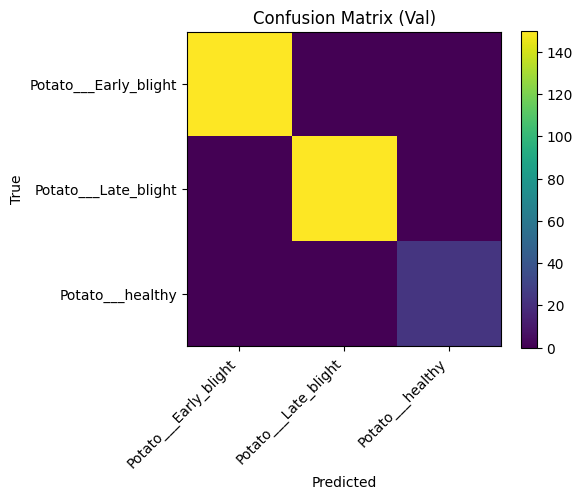

In [8]:
# =========================
# Cell 8: Evaluation Report + Confusion Matrix
# =========================
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.eval()

val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)

print("Final Val Acc:", val_acc)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=ckpt["classes"]))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Plot confusion matrix quickly
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.xticks(range(num_classes), ckpt["classes"], rotation=45, ha="right")
plt.yticks(range(num_classes), ckpt["classes"])
plt.title("Confusion Matrix (Val)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


In [9]:
# =========================
# Cell 9: Production Export
# =========================
prod_path = Path("potato_efficientnetv2s_prod.pth")
torch.save({
    "model_state": model.state_dict(),
    "classes": ckpt["classes"],
    "img_size": ckpt["img_size"],
    "arch": ckpt["arch"],
    "mean": IMAGENET_MEAN,
    "std": IMAGENET_STD
}, prod_path)

print("✅ Production checkpoint saved:", prod_path)


✅ Production checkpoint saved: potato_efficientnetv2s_prod.pth


In [10]:
# =========================
# Cell 1: Paths
# =========================
from pathlib import Path

REAL_ROOT = Path("/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256")

TRAIN_DIR = REAL_ROOT / "Training"
VAL_DIR   = REAL_ROOT / "Validation"
TEST_DIR  = REAL_ROOT / "Testing"

assert TRAIN_DIR.exists()
assert VAL_DIR.exists()
assert TEST_DIR.exists()

print("✅ Real-world dataset found")


✅ Real-world dataset found


In [11]:
# =========================
# Cell 2: Load PV model
# =========================
import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PV_CKPT = "/kaggle/working/potato_efficientnetv2s_prod.pth"

ckpt = torch.load(PV_CKPT, map_location=device)

CLASSES = ckpt["classes"]           # keep exact order
IMG_SIZE = ckpt["img_size"]
MEAN = ckpt["mean"]
STD  = ckpt["std"]

print("Classes:", CLASSES)
print("Image size:", IMG_SIZE)


Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Image size: 384


In [12]:
# =========================
# Cell 3: Model
# =========================
def build_model(num_classes):
    model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

model = build_model(len(CLASSES)).to(device)
model.load_state_dict(ckpt["model_state"], strict=True)

print("✅ Model loaded with PlantVillage weights")


✅ Model loaded with PlantVillage weights


In [13]:
# =========================
# Cell 4: Transforms
# =========================
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.25, 0.25, 0.25, 0.05),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
    transforms.RandomErasing(p=0.15)
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])


In [14]:
# =========================
# Cell 5 (FIXED): Datasets & Loaders with class mapping
# =========================
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np

# These are the PV classes stored in your checkpoint (model output order)
print("PV classes (model output order):", CLASSES)

# PLD folders (real dataset)
tmp = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
print("PLD folders found:", tmp.classes)

# ---- Map PLD folder names -> PV canonical names ----
# PLD names: Early_Blight, Healthy, Late_Blight
# PV names : Potato___Early_blight, Potato___Late_blight, Potato___healthy
PLD_TO_PV = {
    "Early_Blight": "Potato___Early_blight",
    "Late_Blight":  "Potato___Late_blight",
    "Healthy":      "Potato___healthy",
}

# Build desired class_to_idx that matches PV order exactly
pv_to_idx = {c: i for i, c in enumerate(CLASSES)}

# For each PLD folder, assign it the index of the corresponding PV class
new_class_to_idx = {}
for folder_name in tmp.classes:
    if folder_name not in PLD_TO_PV:
        raise ValueError(f"❌ Add mapping for folder: {folder_name}")
    pv_name = PLD_TO_PV[folder_name]
    if pv_name not in pv_to_idx:
        raise ValueError(f"❌ PV class '{pv_name}' not in checkpoint CLASSES={CLASSES}")
    new_class_to_idx[folder_name] = pv_to_idx[pv_name]

print("✅ Forced class_to_idx (PLD folder -> PV index):", new_class_to_idx)

def make_mapped_imagefolder(root, transform):
    ds = datasets.ImageFolder(root, transform=transform)

    # Force mapping & rebuild targets so labels follow PV order
    ds.class_to_idx = new_class_to_idx
    ds.targets = [ds.class_to_idx[ds.classes[y]] for y in ds.targets]
    return ds

train_ds = make_mapped_imagefolder(TRAIN_DIR, train_tfms)
val_ds   = make_mapped_imagefolder(VAL_DIR, val_tfms)
test_ds  = make_mapped_imagefolder(TEST_DIR, val_tfms)

train_loader = DataLoader(train_ds, batch_size=24, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print("✅ DataLoaders ready")
print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))


PV classes (model output order): ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
PLD folders found: ['Early_Blight', 'Healthy', 'Late_Blight']
✅ Forced class_to_idx (PLD folder -> PV index): {'Early_Blight': 0, 'Healthy': 2, 'Late_Blight': 1}
✅ DataLoaders ready
Train/Val/Test sizes: 3251 416 405


In [15]:
# =========================
# Cell 6: Fine-tuning setup
# =========================
use_amp = device.type == "cuda"
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

criterion = nn.CrossEntropyLoss(label_smoothing=0.03)

backbone_params = []
head_params = []

for name, p in model.named_parameters():
    if "classifier" in name:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-5},
        {"params": head_params, "lr": 8e-5},
    ],
    weight_decay=1e-4
)

EPOCHS = 8
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS * len(train_loader)
)


/tmp/ipykernel_24/441635416.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [16]:
# =========================
# Cell 7: Fine-tuning loop
# =========================
from sklearn.metrics import accuracy_score
import numpy as np
import time

def train_one_epoch():
    model.train()
    correct, total, losses = 0, 0, []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        losses.append(loss.item())
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return np.mean(losses), correct / total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    preds_all, labels_all, losses = [], [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)

        losses.append(loss.item())
        preds_all.append(out.argmax(1).cpu().numpy())
        labels_all.append(y.cpu().numpy())

    preds_all = np.concatenate(preds_all)
    labels_all = np.concatenate(labels_all)

    acc = accuracy_score(labels_all, preds_all)
    return np.mean(losses), acc, labels_all, preds_all


In [17]:
best_acc = 0.0
patience = 0
PATIENCE = 3

BEST_PATH = "best_potato_realworld.pth"

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc, _, _ = evaluate(val_loader)

    print(f"[FT] Epoch {epoch}/{EPOCHS} | "
          f"train {tr_loss:.4f}/{tr_acc:.4f} | "
          f"val {va_loss:.4f}/{va_acc:.4f} | "
          f"{time.time()-t0:.1f}s")

    if va_acc > best_acc:
        best_acc = va_acc
        patience = 0
        torch.save({
            "model_state": model.state_dict(),
            "classes": CLASSES,
            "img_size": IMG_SIZE,
            "mean": MEAN,
            "std": STD
        }, BEST_PATH)
        print("✅ Saved best fine-tuned model")
    else:
        patience += 1
        if patience >= PATIENCE:
            print("🛑 Early stopping")
            break

print("Best validation accuracy:", best_acc)


/tmp/ipykernel_24/2359967458.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[FT] Epoch 1/8 | train 0.7227/0.7038 | val 0.3533/0.9135 | 72.4s
✅ Saved best fine-tuned model


/tmp/ipykernel_24/2359967458.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[FT] Epoch 2/8 | train 0.3252/0.9169 | val 0.2029/0.9615 | 57.9s
✅ Saved best fine-tuned model


/tmp/ipykernel_24/2359967458.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[FT] Epoch 3/8 | train 0.2386/0.9545 | val 0.1775/0.9663 | 55.7s
✅ Saved best fine-tuned model


/tmp/ipykernel_24/2359967458.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[FT] Epoch 4/8 | train 0.2211/0.9612 | val 0.1450/0.9904 | 56.2s
✅ Saved best fine-tuned model


/tmp/ipykernel_24/2359967458.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[FT] Epoch 5/8 | train 0.1967/0.9711 | val 0.1415/0.9928 | 57.6s
✅ Saved best fine-tuned model


/tmp/ipykernel_24/2359967458.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[FT] Epoch 6/8 | train 0.1955/0.9655 | val 0.1387/0.9928 | 56.8s


/tmp/ipykernel_24/2359967458.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[FT] Epoch 7/8 | train 0.1901/0.9717 | val 0.1311/0.9976 | 56.7s
✅ Saved best fine-tuned model


/tmp/ipykernel_24/2359967458.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[FT] Epoch 8/8 | train 0.1976/0.9686 | val 0.1378/0.9928 | 57.7s
Best validation accuracy: 0.9975961538461539
